In [1]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
from scipy.stats import norm
import astropy.units as u
import matplotlib.pyplot as plt
from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad,sonoff
from dysh.spectra.scan import PSScan, GBTPSScan
import pandas
from copy import deepcopy
pandas.set_option('display.max_rows', 100)
from astropy.modeling.fitting import LevMarLSQFitter,LinearLSQFitter
from specutils import Spectrum1D, SpectrumList,SpectralRegion
from specutils.fitting import fit_continuum
import matplotlib.pyplot as plt
from dysh.spectra import dcmeantsys


### Create a gaussian spectrum with noise, compute the baseline, remove it, then add the baseline back in

In [2]:
npts = 1000
x = np.arange(npts)
#print(x)
y = 3.1415927+np.random.rand(npts)+1000*norm(loc=npts/2,scale=50).pdf(x)
#y=1000*norm(loc=npts/2,scale=100).pdf(x)
s = Spectrum(flux=y*u.K,spectral_axis=x*u.um,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))
#print(y)
#s._spectral_axis.unit

### compute the baseline, exclude channels 300 to 700, don't remove it.

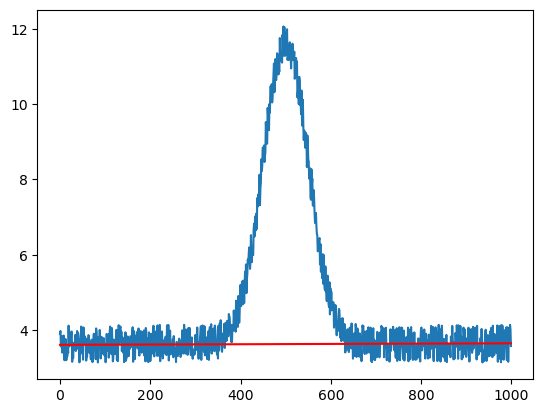

In [3]:
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
s.baseline(1,exclude=[300,700],remove=False)
ax.plot(s.spectral_axis,s._baseline_model(s.spectral_axis),color='r')

### print some statistics, show the baseline model function

In [4]:
print(s.stats())
s.bshow()

(<Quantity 4.63236899 K>, 2.1724917969801405, <Quantity 3.14261237 K>, <Quantity 12.05846384 K>)
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                  c1          
            K                 K / um        
    ----------------- ----------------------
    3.610923338147421 3.9628551603375336e-05


### now do it and remove the baseline

(<Quantity 1.00165119 K>, 2.1724706599492363, <Quantity -0.50540329 K>, <Quantity 8.42792437 K>)
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                  c1          
            K                 K / um        
    ----------------- ----------------------
    3.610923338147421 3.9628551603375336e-05


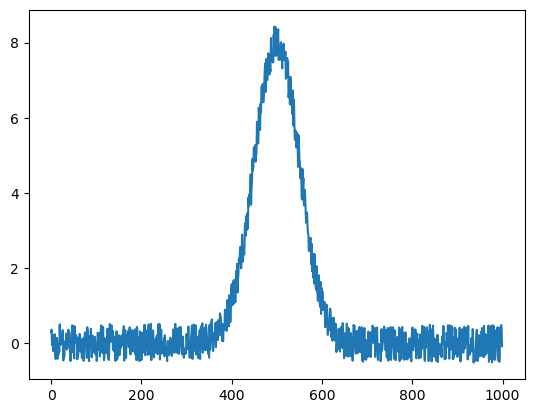

In [5]:
s = Spectrum(flux=y*u.K,spectral_axis=x*u.um,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))
s.baseline(1,exclude=[300,700],remove=True)
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
print(s.stats())
s.bshow()

In [6]:
### undo the baseline removal.  Stats shows it has been added back in and the spectrum is restored

In [7]:
s._undo_baseline()
print(s.stats())
s.bshow()


(<Quantity 4.63236899 K>, 2.1724917969801405, <Quantity 3.14261237 K>, <Quantity 12.05846384 K>)
baseline model None


In [8]:
f = '/data/gbt/examples/misc/ngc5291.fits'
f = '/data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
#f = '/data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
p = GBTFITSLoad(f)

==SDFITSLoad /data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits
doing pandas for HDU 1
==GBTLoad /data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits
0 OBJECT: ['NGC2415']
0 SCAN: [152, 153]
0 SAMPLER: ['A1_0', 'A2_0', 'A1_1', 'A2_1', 'A1_2', 'A2_2', 'A1_3', 'A2_3', 'A1_4', 'A2_4']
0 SIG: ['T']
0 CAL: ['F', 'T']
0 PROCSEQN: [1, 2]
0 PROCSIZE: [2]
0 OBSMODE: ['OnOff:PSWITCHON:TPWCAL', 'OnOff:PSWITCHOFF:TPWCAL']
0 SIDEBAND: ['L']


In [9]:
p.summary()[0]

/home/mpound/src/dysh/src/dysh/fits/gbtfitsload.py:85: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  _df = df[df.columns & show].copy()


,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,IFNUM,FEED,AZIMUTH,ELEVATIO,FDNUM
0,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
1,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
2,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
3,152,NGC2415,3784.0,OnOff,1,1.420406,0,1,285.951496,42.100624,0
4,152,NGC2415,3784.0,OnOff,1,1.612231,1,1,285.951496,42.100624,0
...,...,...,...,...,...,...,...,...,...,...,...
6035,153,NGC2415,3784.0,OnOff,2,1.667359,3,1,287.149353,40.652970,0
6036,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0
6037,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0
6038,153,NGC2415,3784.0,OnOff,2,1.720530,4,1,287.149353,40.652970,0


In [10]:
p._hdu[1].header['TUNIT11']


'Hz'

In [11]:
columns = ["SCAN","PROC","PROCSEQN","IFNUM","PLNUM","SIG","CAL","TSYS","TCAL", "OBSMODE"]
df = p._ptable[0]
df.columns
df[df.columns & columns]#[0:50]
#df[(df['SIG'] == 'F') & (df['CAL']=='T')][(df.columns & columns)]

/tmp/ipykernel_419710/161940593.py:4: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  df[df.columns & columns]#[0:50]


,TSYS,SCAN,OBSMODE,TCAL,PROCSEQN,SIG,CAL,IFNUM,PLNUM,PROC
0,1.0,152,OnOff:PSWITCHON:TPWCAL,1.428060,1,T,F,0,1,OnOff
1,1.0,152,OnOff:PSWITCHON:TPWCAL,1.428060,1,T,T,0,1,OnOff
2,1.0,152,OnOff:PSWITCHON:TPWCAL,1.455164,1,T,F,0,0,OnOff
3,1.0,152,OnOff:PSWITCHON:TPWCAL,1.455164,1,T,T,0,0,OnOff
4,1.0,152,OnOff:PSWITCHON:TPWCAL,1.602189,1,T,F,1,1,OnOff
...,...,...,...,...,...,...,...,...,...,...
6035,1.0,153,OnOff:PSWITCHOFF:TPWCAL,1.470465,2,T,T,3,0,OnOff
6036,1.0,153,OnOff:PSWITCHOFF:TPWCAL,1.368713,2,T,F,4,1,OnOff
6037,1.0,153,OnOff:PSWITCHOFF:TPWCAL,1.368713,2,T,T,4,1,OnOff
6038,1.0,153,OnOff:PSWITCHOFF:TPWCAL,1.419782,2,T,F,4,0,OnOff


In [12]:
df = p._ptable[0]
df = df[(df['CAL'] == 'T') & (df['_OBSTYPE'] == "PSWITCHON")]
df[df["SCAN"].isin([152])].index

Int64Index([   1,    3,    5,    7,    9,   11,   13,   15,   17,   19,
            ...
            3001, 3003, 3005, 3007, 3009, 3011, 3013, 3015, 3017, 3019],
           dtype='int64', length=1510)

In [13]:
df = p._ptable[0]
df=df[df["SCAN"].isin([152])]
df=p.select("CAL","T",df)
df.index

Int64Index([   1,    3,    5,    7,    9,   11,   13,   15,   17,   19,
            ...
            3001, 3003, 3005, 3007, 3009, 3011, 3013, 3015, 3017, 3019],
           dtype='int64', length=1510)

In [14]:
cr= p.calonoff_rows([152,153])
cr["ON"][-1],cr["OFF"][-1]

(6039, 6038)

In [15]:
psscan = p.getps(152)

PSSCAN nrows = 3020


In [16]:
psscan.calibrate()

In [17]:
psscan._calibrated[0]

array([ 0.8848908 ,  0.7445654 ,  2.6308112 , ...,  0.26730862,
       -0.7553267 , -0.6472924 ], dtype=float32)

(<SpectralAxis 
    (observer to target:
       radial_velocity=0.0 km / s
       redshift=0.0
     doppler_rest=1420405751.7 Hz
     doppler_convention=doppler_radio)
   [1.41426368e+09, 1.41426297e+09, 1.41426225e+09, ..., 1.39082833e+09,
    1.39082761e+09, 1.39082690e+09] Hz>,
 <SpectralAxis 
    (observer to target:
       radial_velocity=0.0 km / s
       redshift=0.0
     doppler_rest=1667359000.0 Hz
     doppler_convention=doppler_radio)
   [1.66127296e+09, 1.66127225e+09, 1.66127153e+09, ..., 1.63783761e+09,
    1.63783689e+09, 1.63783618e+09] Hz>)

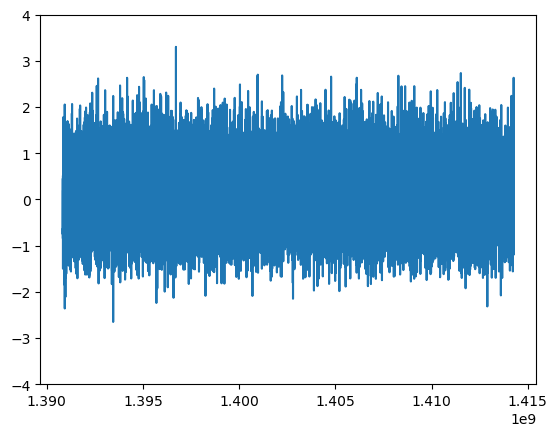

In [28]:
fig,ax = plt.subplots()
ax.set_ylim([-4,4])
ax.plot(psscan.calibrated(0).spectral_axis,psscan.calibrated(0).flux)
psscan.calibrated(500).spectral_axis,psscan.calibrated(75).spectral_axis

17.799646995712777


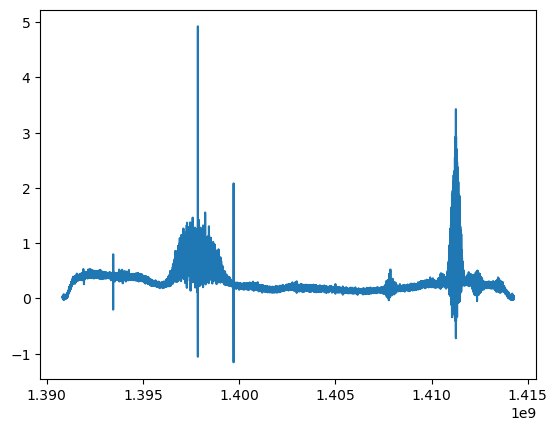

In [24]:
avg = Spectrum(spectral_axis=psscan.calibrated(0).spectral_axis,flux=np.mean(psscan._calibrated)*u.K)
fig,ax=plt.subplots()
ax.plot(avg.spectral_axis,avg.flux)
print(np.mean(psscan.tsys))

In [21]:
len(psscan._calibrated)

1510

In [ ]:
df = p._ptable[0]
len(p.select('OBJECT','NGC2415',p._ptable[0]))//p.npol(0)

In [ ]:
p.index(0).iloc[psscan._scanrows["OFF"]]["CAL"]

In [ ]:
psscan.calibrate()

In [ ]:
df = p._ptable[0]
scans = [152,153]
df2=df[df["SCAN"].isin([152])]
df3=df[df["SCAN"].isin([153])]
df4=df[df["SCAN"].isin([156])]
un = df2.index.union(df3.index)
un2=df2.index
un3=df3.index
df["SCAN"].iloc[un2]
df3.reindex(un2).index

In [ ]:
on = [152,154,156]
off = [153,155,157]
scans = [152,155]
onrequested = set(on).intersection(scans)
offrequested = set(off).intersection(scans)
sons = list(onrequested.copy())
soffs = list(offrequested.copy())
missingoff = []
missingon = []
setoff = set(off)
seton = set(on)
for i in onrequested:
    expectedoff = i+1
    if len(setoff.intersection([expectedoff])) == 0:
        missingoff.append(expectedoff)
    else:
        soffs.append(expectedoff)
for i in offrequested:
    expectedon = i-1
    if len(seton.intersection([expectedon])) == 0:
        missingon.append(expectedon)
    else:
        sons.append(expectedon)
if len(missingoff) > 0:
    raise ValueError(f"For the requested ON scans {onrequested}, the OFF scans {missingoff} were not present in bintable {bintable}")
if len(missingon) > 0:
    raise ValueError(f"For the requested OFF scans {offrequested}, the ON scans {missingon} were not present in bintable {bintable}")
print("ON",sorted(sons))
print("OFF",sorted(soffs))

In [ ]:
scanlist=p.onoff_scan_list()
print(scanlist)
#scanlist = p.onoff_scan_list([152])
#print(scanlist)
scanlist = p.onoff_scan_list([153])
print(scanlist)
scanlist = p.onoff_scan_list([152,153])
print(scanlist)
scanlist = p.onoff_scan_list(152)
print(scanlist)

In [ ]:
print(sonoff(p.index(0)["SCAN"],p.index(0)["PROCSEQN"]))
myscans = set(sorted([153,155]))
scanlist=p.onoff_scan_list()
print(scanlist)
allscans = set(sorted(scanlist["ON"]+scanlist["OFF"]+[1,2,3,4,5]))
print(allscans)
z=allscans.intersection(myscans)
zz =allscans.difference(myscans)
zzz=myscans.difference(allscans)
print(z,zz,zzz)

In [ ]:
psscan = p.getps(scans=[152])

In [ ]:
df = p._ptable[0]
rows=list(df[df["SCAN"].isin(scans["ON"])].index)
df

In [ ]:
rows=p.onoff_rows()
rows

In [ ]:
show = ["SCAN", "PROCSEQN", "PROCSIZE", "_OBSTYPE"]
df=df[df.columns & show]
df[df["_OBSTYPE"]=="PSWITCHOFF"]

In [ ]:
dict(p._ptable[0].iloc[0])

In [ ]:
df["RESTFREQ"]/=1E9
df["RESTFREQ"]

In [ ]:
show = ["SCAN", "OBJECT", "OBSMODE", "VELOCITY", "PROCSCAN", "PROCSEQN", "PROCTYPE", "PROCSIZE", "RESTFREQ", "IFNUM","FEED", "AZIMUTH", "ELEVATIO", "FDNUM"] 
scan = [60,61]
_df = df[df.columns & show].reindex(columns=show)

In [ ]:
_df["OBSMODE"].str.split(':',expand=True)

In [ ]:

_df[(_df["SCAN"]>=scan[0]) & ( _df["SCAN"] <= scan[1])]

In [ ]:
df["SCAN"]

In [ ]:
df['PROCTYPE']